# Boston Celtics Specific Model

In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Importing 4 Seasons of NBA Data (2020-2024)

In [14]:
season_20 = pd.read_csv('../data_generation/output_data/2020-21_data.csv')
season_21 = pd.read_csv('../data_generation/output_data/2021-22_data.csv')
season_22 = pd.read_csv('../data_generation/output_data/2022-23_data.csv')
season_23 = pd.read_csv('../data_generation/output_data/2023-24_data.csv')

combined_seasons = pd.concat([season_20, season_21, season_22, season_23], ignore_index=True)
combined_season = combined_seasons.drop_duplicates()
combined_seasons = combined_seasons.reset_index(drop=True)

# combined_seasons.head(10)

## Mapping Team ID to City

In [18]:
TEAM_CITY_MAPPING = {
    1610612737: "Atlanta, GA",
    1610612738: "Boston, MA",
    1610612739: "Cleveland, OH",
    1610612740: "New Orleans, LA",
    1610612741: "Chicago, IL",
    1610612742: "Dallas, TX",
    1610612743: "Denver, CO",
    1610612744: "San Francisco, CA",
    1610612745: "Houston, TX",
    1610612746: "Los Angeles, CA (Lakers)",
    1610612747: "Los Angeles, CA (Clippers)",
    1610612748: "Miami, FL",
    1610612749: "Milwaukee, WI",
    1610612750: "Minneapolis, MN",
    1610612751: "Brooklyn, NY",
    1610612752: "New York, NY",
    1610612753: "Orlando, FL",
    1610612754: "Indianapolis, IN",
    1610612755: "Philadelphia, PA",
    1610612756: "Phoenix, AZ",
    1610612757: "Portland, OR",
    1610612758: "Sacramento, CA",
    1610612759: "San Antonio, TX",
    1610612760: "Oklahoma City, OK",
    1610612761: "Toronto, ON (Canada)",
    1610612762: "Salt Lake City, Utah",
    1610612763: "Memphis, TN",
    1610612764: "Washington, D.C.",
    1610612765: "Detroit, MI",
    1610612766: "Charlotte, NC"
}

boston_celtics = 1610612738
boston_data = combined_seasons.loc[combined_seasons["teamId"] == boston_celtics]

# boston_data.head(10)


## Prepare features and target value for the Boston Celtics

In [31]:
input = boston_data.drop(columns=['PTS'])
target = boston_data['PTS']

spearman_corr = pd.read_csv('../data_generation/output_data/spearman_corr_features.csv')

selected_features = spearman_corr['Feature'].tolist()

existing_features = [feature for feature in selected_features if feature in input.columns]

input = boston_data[existing_features]
input = input.dropna(axis=1)
print(input.info()) # 318 entries, 126 columns

# Split data est
input_train, input_test, target_train, target_test = train_test_split(input, target, test_size=0.2, random_state=0)

# Scaling features
scaler = StandardScaler()
input_train = scaler.fit_transform(input_train)
input_test = scaler.transform(input_test)

<class 'pandas.core.frame.DataFrame'>
Index: 318 entries, 20 to 9526
Columns: 126 entries, fieldGoalPercentage_my_player_1 to OPPONENT_WIN_PCT
dtypes: float64(123), int64(3)
memory usage: 315.5 KB
None


## Define the Model

In [22]:
# Initialize sequential model 
model = Sequential([
    Input(shape=(input_train.shape[1],)), # define input shape
    Dense(64, activation='relu'), # first hidden layer with 64 units
    Dropout(0.2),
    Dense(32, activation='relu'), # second hidden layer with 32 units
    Dense(1) # OUtput with target (PTS)
])

# Compile the model 
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(input_train, target_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 13470.5205 - mae: 115.3036 - val_loss: 13619.9824 - val_mae: 116.0934
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13188.4697 - mae: 114.0675 - val_loss: 13459.3330 - val_mae: 115.3954
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13172.1357 - mae: 113.9951 - val_loss: 13288.0010 - val_mae: 114.6496
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12790.6650 - mae: 112.2194 - val_loss: 13095.0479 - val_mae: 113.8040
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12590.9160 - mae: 111.4007 - val_loss: 12864.0547 - val_mae: 112.7835
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12309.7900 - mae: 110.2041 - val_loss: 12582.9277 - val_mae: 111.5308
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11923.2344 - mae: 108.3785 - val_loss: 12249.6670 - val_mae: 110.0254
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11660.4609 - mae: 107.0777 - val_loss: 11850.8555 - val_mae: 

## Visualize History

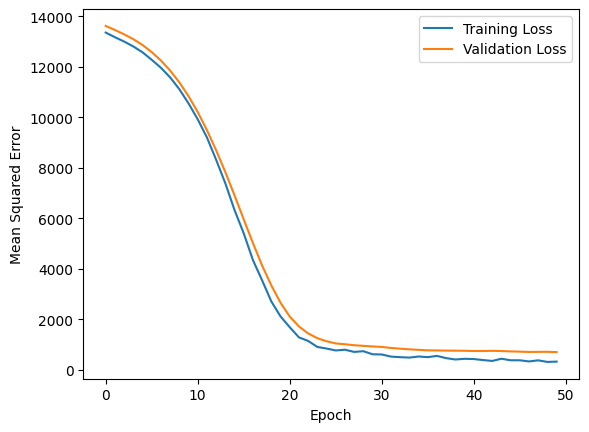

In [24]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

## Evaluation and Sample Target Prediction

In [32]:
# Evaluate model and test data
test_loss, test_mae = model.evaluate(input_test, target_test)

# Target prediction
sample_predictions = model.predict(input_test)

mse = mean_squared_error(target_test, sample_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(target_test, sample_predictions)

print("\n--- Regression Metrics ---")
print(f"Test Loss (MSE from model): {test_loss:.2f}")
print(f"Test MAE (from model): {test_mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Squared (R²): {r2:.2f}")

print("Sample Prediction (PTS):", sample_predictions[:10].flatten())
print("Actual Values (PTS):", target_test[:10].values)

bos_results = pd.DataFrame({
    "Actual PTS": target_test,
    "Predicted PTS": sample_predictions.flatten()
})

# bos_results.to_csv("boston_celtics_model_eval.csv", index=False)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 682.3865 - mae: 21.2291
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

--- Regression Metrics ---
Test Loss (MSE from model): 713.21
Test MAE (from model): 21.63
Mean Squared Error (MSE): 713.21
Root Mean Squared Error (RMSE): 26.71
R-Squared (R²): -2.67
Sample Prediction (PTS): [120.49426  114.38086   72.3569   128.16924   94.969215  95.53525
 125.48424   96.14725   94.501656  95.55707 ]
Actual Values (PTS): [119 133 119 132 142 143 119 123 117 106]
